## Credit Card Deafult Prediction

### Objectives
In this notebook, I will built predictive models to predict the risk of credit card customers being default.
I will aim to built the models to fit the 2 usecases as follows
1. Predicting the risk of new customers being default
2. Predicting the risk of current customers being default in the next month

### Dataset Information
The dataset used here is from https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients which contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

There are 25 variables in the dataset as below.

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)

Let's first take a look at the data and do some data cleaning

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns

In [31]:
df = pd.read_excel('default_data.xls', skiprows=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [32]:
# let change some column names
# change to lower cases
df.columns = [col.lower() for col in df.columns]

# shorten the label column name
df = df.rename(columns={'default payment next month': 'default'})

# Set data types of categorical columns
cat_cols = ['sex', 'education', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
df = df.astype({col:'category' for col in cat_cols})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         30000 non-null  int64   
 1   limit_bal  30000 non-null  int64   
 2   sex        30000 non-null  category
 3   education  30000 non-null  category
 4   marriage   30000 non-null  category
 5   age        30000 non-null  int64   
 6   pay_0      30000 non-null  category
 7   pay_2      30000 non-null  category
 8   pay_3      30000 non-null  category
 9   pay_4      30000 non-null  category
 10  pay_5      30000 non-null  category
 11  pay_6      30000 non-null  category
 12  bill_amt1  30000 non-null  int64   
 13  bill_amt2  30000 non-null  int64   
 14  bill_amt3  30000 non-null  int64   
 15  bill_amt4  30000 non-null  int64   
 16  bill_amt5  30000 non-null  int64   
 17  bill_amt6  30000 non-null  int64   
 18  pay_amt1   30000 non-null  int64   
 19  pay_amt2   30000 non-null

### Exploratory Analysis

Let's start with checking if the data is imbalanced meaning that the default cases are much fewer than the normal case.

0    23364
1     6636
Name: default, dtype: int64
The default case is 22.12% of all the data


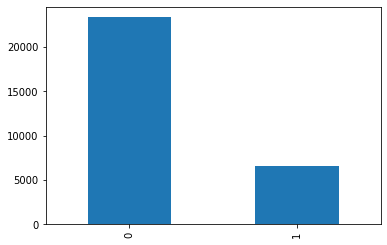

In [33]:
count = df.default.value_counts()
print(count)
count.plot(kind='bar')
print(f'The default case is {count[1]/(count[1] + count[0])*100:.2f}% of all the data')

The default cases are fewer than the normal cases but it's not that imbalanced. So I'll not use any resampling techniques here to fix this for now.

Next let's make some plots to see the distributions of each features

<AxesSubplot: xlabel='limit_bal', ylabel='Count'>

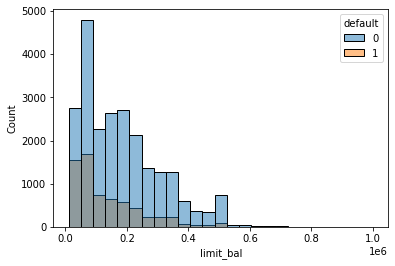

In [34]:
sns.histplot(df, x='limit_bal', hue='default', bins=25)

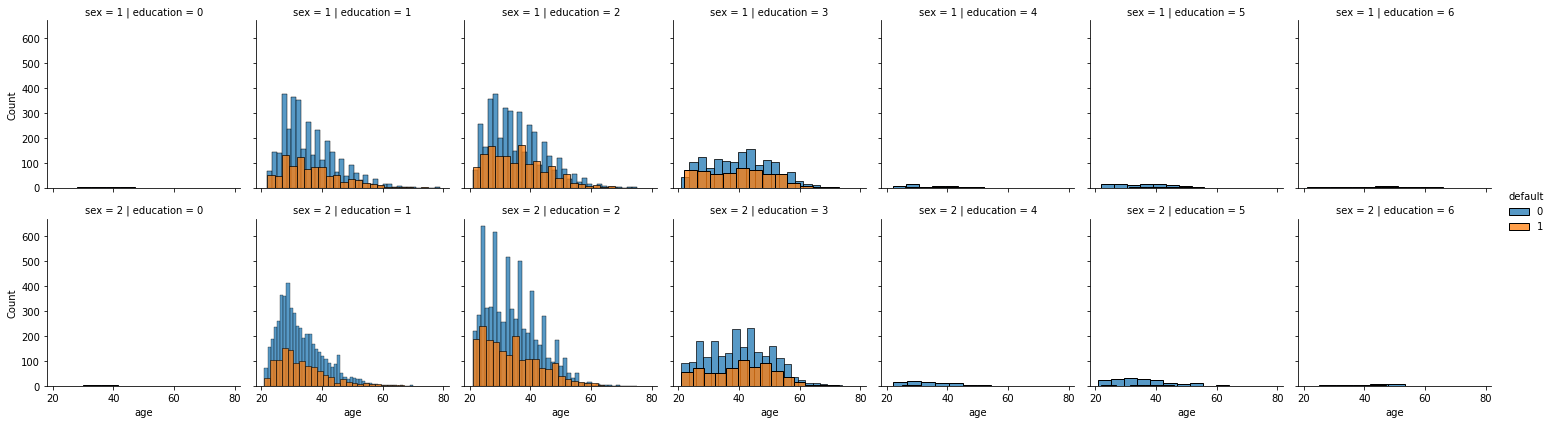

In [35]:
g = sns.FacetGrid(df, col="education", row="sex", hue='default')
g.map(sns.histplot, "age")
g.add_legend()

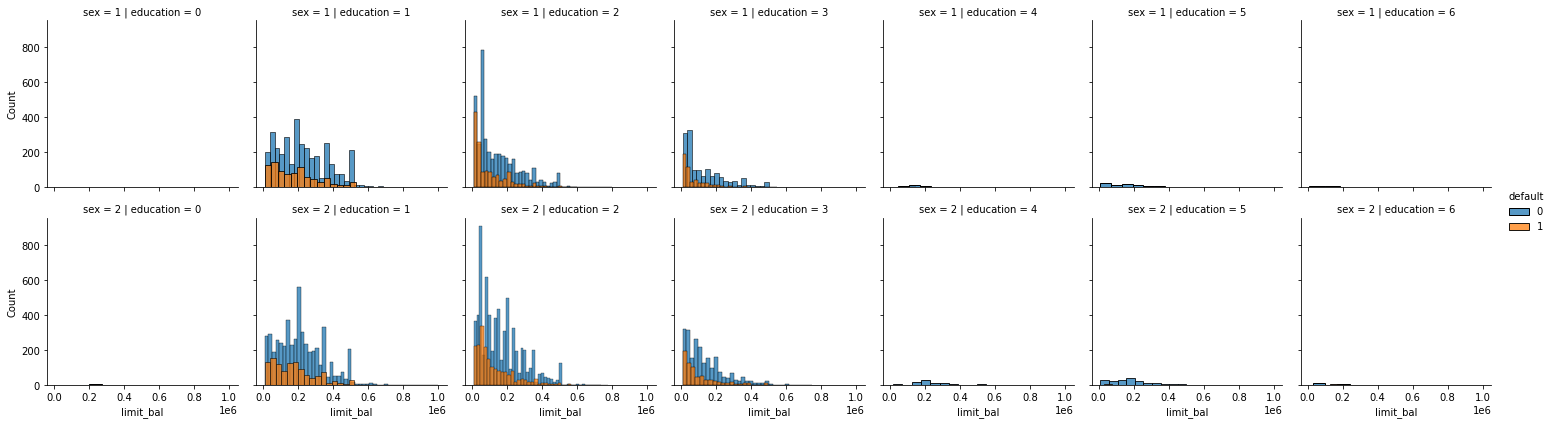

In [36]:
g = sns.FacetGrid(df, col="education", row="sex", hue='default')
g.map(sns.histplot, "limit_bal")
g.add_legend()

Looking at these plots, it seems like the distribution of default cases are quite similar with the normal cases within the same group.
I'll then focus more on the prediction of the default cases in the next section.

### Case 1: Predicting credit card default for a new customer issuing a credit card

In this section I will use only demographic infomation and limit balance to predict the probability of a new customer being default.
We can think of this usecase as when a new customer is issuing a new credit card and we want to find the probability of credit card default.
In this case we don't have data about their credit card usage (new customers), so we will only use demo graphic information instead.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, plot_roc_curve, ConfusionMatrixDisplay

In [38]:
# Prepare data to keep only relevant columns
kept_cols = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'default']
df_demo = df[kept_cols]
df_demo.head()

,limit_bal,sex,education,marriage,age,default
0,20000,2,2,1,24,1
1,120000,2,2,2,26,1
2,90000,2,2,2,34,0
3,50000,2,2,1,37,0
4,50000,1,2,1,57,0


### logistic regression

Let's first try logistic regression model.
Since some columns are actually categorical columns, we need to transform this using one-hot encoding before training a logistic regression model.

In [39]:
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   limit_bal  30000 non-null  int64   
 1   sex        30000 non-null  category
 2   education  30000 non-null  category
 3   marriage   30000 non-null  category
 4   age        30000 non-null  int64   
 5   default    30000 non-null  int64   
dtypes: category(3), int64(3)
memory usage: 791.8 KB


In [40]:
# convert categorical columns to binary columns using onehot encoding
df_demo_oh = pd.get_dummies(df_demo)
df_demo_oh.head()

,limit_bal,age,default,sex_1,sex_2,education_0,education_1,education_2,education_3,education_4,education_5,education_6,marriage_0,marriage_1,marriage_2,marriage_3
0,20000,24,1,0,1,0,0,1,0,0,0,0,0,1,0,0
1,120000,26,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,90000,34,0,0,1,0,0,1,0,0,0,0,0,0,1,0
3,50000,37,0,0,1,0,0,1,0,0,0,0,0,1,0,0
4,50000,57,0,1,0,0,0,1,0,0,0,0,0,1,0,0


In [41]:
# Split the data into train and test sets
X = df_demo_oh.drop(columns=['default']).values
y = df_demo_oh.default.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [42]:
# Train a logistic regression model
lr_clf = LogisticRegression(random_state=0).fit(X_train, y_train)

Since we will create various models, let's define a function to conveniently evaluate performance of each model.

In [43]:
def evaluate_model(model, X_test, y_test, cutoff=0.5):
    """Function to evaluate the model using test set"""
    # make predictions
    pred_prob = model.predict_proba(X_test)[:, 1]
    # Use probability of 0.5 as a cutoff
    pred = (pred_prob > cutoff).astype(int)

    # Some performance metrics
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)

    print('Accuracy =', accuracy)
    print('Recall of positive class =', recall)
    conf_mat = confusion_matrix(y_test, pred)
    ConfusionMatrixDisplay(conf_mat).plot()
    plot_roc_curve(model, X_test, y_test)

Accuracy = 0.7788333333333334
Recall of positive class = 0.0


c:\Users\Naphat\anaconda3\envs\env_6420_conda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


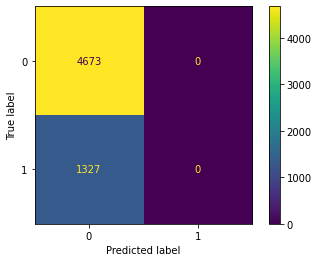

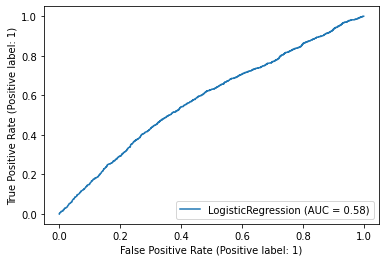

In [44]:
evaluate_model(lr_clf, X_test, y_test)

Here we observe that the accuracy from the logistic regression model is not bad but recall is 0, which means that the model predict all data points as not default in this case. This is again not useful at all.
We can try adjust the cutoff to include more positive cases.


Accuracy = 0.7438333333333333
Recall of positive class = 0.12660135644310475


c:\Users\Naphat\anaconda3\envs\env_6420_conda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


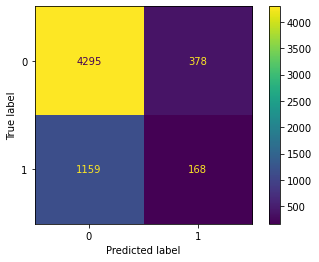

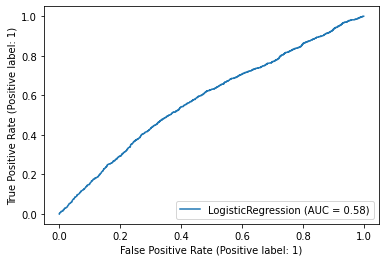

In [45]:
# Change the cutoff to 0.35
evaluate_model(lr_clf, X_test, y_test, cutoff=0.35)

Here using cutoff at 0.35 we captured some default cases but also made a lot of false positive. So we need to think about the tradeoff or the cost between both errors.

Notice that the AUC is only 0.58 which is not much better than just a random chance. So this is either because the model is not good enough or the demographic data we have is not good enough to predict the default.

Next let's try a tree-based model to see if we can do better with the same dataset.

### Gradient Boosting Classifier

Here I will use gradient boosting classifier which is an ensemble model to do the same task as above.

In [46]:
gb_clf = GradientBoostingClassifier().fit(X_train, y_train)

Accuracy = 0.7785
Recall of positive class = 0.0015071590052750565


c:\Users\Naphat\anaconda3\envs\env_6420_conda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


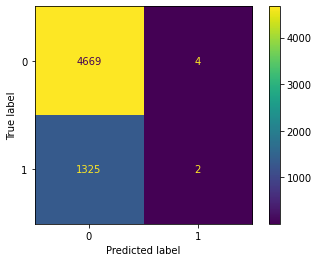

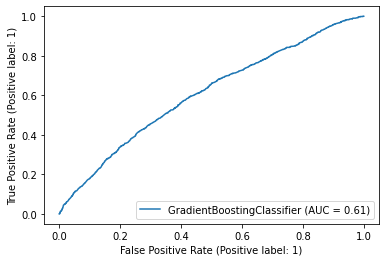

In [47]:
evaluate_model(gb_clf, X_test, y_test)

Here we see that the AUC of the gradient boosting model is 0.61 which is not much better than logistic regression. We can also do hyperparameter tuning here as well but it might not make much different.

This suggests that using only demographic information alone to predict the default is not enough, we may need other information (features) with more predictive power such as customers' income to train a better model for this usecase.

### Case 2: Predicting the probability of being default for current customers

For this usecase, I will use all the historical information about credit card usage and bill payment to predict defualt for the next month.

In [48]:
# Here we use data with all feaetures about historical credit card usage and payment
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         30000 non-null  int64   
 1   limit_bal  30000 non-null  int64   
 2   sex        30000 non-null  category
 3   education  30000 non-null  category
 4   marriage   30000 non-null  category
 5   age        30000 non-null  int64   
 6   pay_0      30000 non-null  category
 7   pay_2      30000 non-null  category
 8   pay_3      30000 non-null  category
 9   pay_4      30000 non-null  category
 10  pay_5      30000 non-null  category
 11  pay_6      30000 non-null  category
 12  bill_amt1  30000 non-null  int64   
 13  bill_amt2  30000 non-null  int64   
 14  bill_amt3  30000 non-null  int64   
 15  bill_amt4  30000 non-null  int64   
 16  bill_amt5  30000 non-null  int64   
 17  bill_amt6  30000 non-null  int64   
 18  pay_amt1   30000 non-null  int64   
 19  pay_amt2   30000 non-null

#### Logistic Regression
Let's try using logistic regression again

In [69]:
# convert categorical columns to binary columns using onehot encoding
df_oh = pd.get_dummies(df)
df_oh.head()

,id,limit_bal,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,...,pay_6_-2,pay_6_-1,pay_6_0,pay_6_2,pay_6_3,pay_6_4,pay_6_5,pay_6_6,pay_6_7,pay_6_8
0,1,20000,24,3913,3102,689,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,120000,26,2682,1725,2682,3272,3455,3261,0,...,0,0,0,1,0,0,0,0,0,0
2,3,90000,34,29239,14027,13559,14331,14948,15549,1518,...,0,0,1,0,0,0,0,0,0,0
3,4,50000,37,46990,48233,49291,28314,28959,29547,2000,...,0,0,1,0,0,0,0,0,0,0
4,5,50000,57,8617,5670,35835,20940,19146,19131,2000,...,0,0,1,0,0,0,0,0,0,0


In [70]:
# Split the data into train and test sets. Also remove the id column.
X = df_oh.drop(columns=['id', 'default']).values
y = df_oh.default.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [71]:
# Train a logistic regression model
clf_all = LogisticRegression(random_state=0,  max_iter=200).fit(X_train, y_train)

Accuracy = 0.7788333333333334
Recall of positive class = 0.0


c:\Users\Naphat\anaconda3\envs\env_6420_conda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


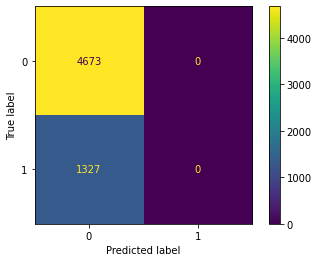

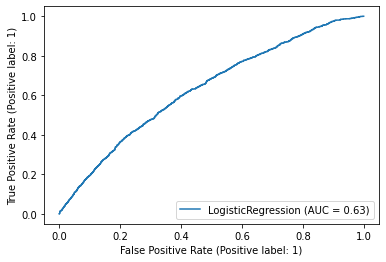

In [72]:
evaluate_model(clf_all, X_test, y_test)

Using all the billing and payment data to train, we can improve the AUC of the logistic regression to 0.63 which is still not good. So let's try a tree-based model as well.

### Gradient Boosting Classifier

In [74]:
# Split the data into train and test sets. Also remove the id column.
X = df.drop(columns=['id', 'default']).values
y = df.default.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [75]:
gb_clf_all = GradientBoostingClassifier(max_depth=5, learning_rate=0.01).fit(X_train, y_train)

Accuracy = 0.815
Recall of positive class = 0.28560663149962323


c:\Users\Naphat\anaconda3\envs\env_6420_conda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


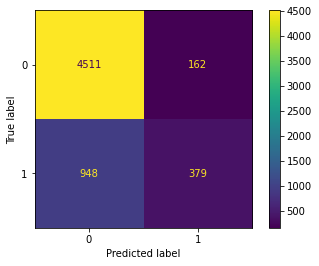

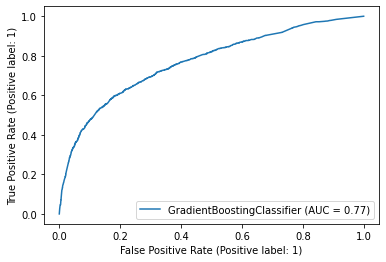

In [76]:
evaluate_model(gb_clf_all, X_test, y_test)

Here the AUC has improved a lot to 0.77 using Gradient Boosting Classifier. THe accuracy also increased to 81.5%. Next let's try to perform hyperparameter tuning to improve the performance of the model.

### Hyper Parameter Tuning for Gradient Boosting Classifier

There are a few ways to perform hyperparameter tuning. One common method is to use grid search to scan (exhaust) over all the parameter space to find the best combination of parameters.

However, it's known to be computational expensive and might take long time to run if the parameter space is large.

Here I'll use baysian optimization instead to perform hyperparameter tuning, which is fast and effective.

In [56]:
from skopt import BayesSearchCV
from skopt.space.space import Real, Integer

In [77]:
# Define search space
param_grid = {
    "learning_rate": Real(0.01, 0.3),
    "max_depth":Integer(3, 15),
    'min_samples_split': Real(0.01, 1),
    'min_samples_leaf': Real(0.01, 0.5),
    'max_features': Integer(1, X_train.shape[1]),
    "n_estimators":Integer(100, 300)
    }

search = BayesSearchCV(GradientBoostingClassifier(), 
                    search_spaces=param_grid,
                    scoring='f1',
                    n_jobs=-1,
                    cv=3)

search.fit(X_train, y_train)

BayesSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
              scoring='f1',
              search_spaces={'learning_rate': Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=15, prior='uniform', transform='normalize'),
                             'max_features': Integer(low=1, high=23, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Real(low=0.01, high=0.5, prior='uniform', transform='normalize'),
                             'min_samples_split': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=300, prior='uniform', transform='normalize')})

In [78]:
print(search.best_params_)
print(search.best_score_) # F1 score

OrderedDict([('learning_rate', 0.3), ('max_depth', 5), ('max_features', 18), ('min_samples_leaf', 0.01), ('min_samples_split', 0.7721217337112587), ('n_estimators', 164)])
0.4830847217296576


In [79]:
gb_clf_all = GradientBoostingClassifier(**search.best_params_).fit(X_train, y_train)

Accuracy = 0.8185
Recall of positive class = 0.3707611152976639


c:\Users\Naphat\anaconda3\envs\env_6420_conda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


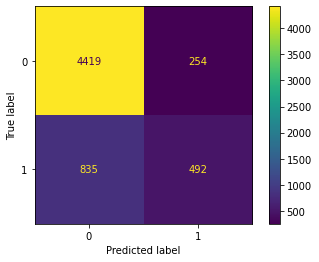

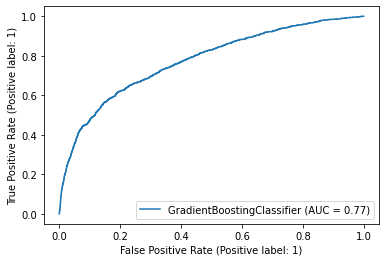

In [80]:
evaluate_model(gb_clf_all, X_test, y_test, cutoff=0.5)

Hyperparameter tuning can improve the model performance a little with accuracy of 81.85% and recall of positive class of 0.37. However, the AUC is still at 0.77.

### Feature importance
One benefit of using tree-based models is ability to rank importance of all features. This is useful to help us better understand which features affect the result of make predictions.

<AxesSubplot: >

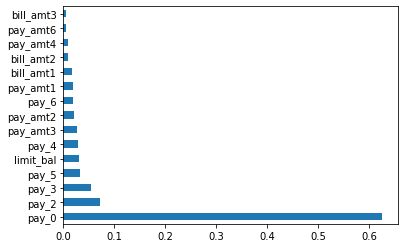

In [93]:
feature_importance = pd.Series(gb_clf_all.feature_importances_, index=df.drop(columns=['id', 'default']).columns)
feature_importance.sort_values(ascending=False).iloc[:15].plot.barh()

Here we see that pay_0 is the most important feature to calculate the risk. This makes sense since it's the information about previous month's payment status which should have high predictive power to determine whether or not they will default in the next month.

### Summary
Tree-based models such as Gradient Boosting Classifier performed better than linear models such as linear regression to predict the risk of creditcard customers getting default.
To make use of this model choosing the right cutoff is important. Choosing a low cutoff will result in higher recall meaning that we will capture more actual default cases, but it will lead to more false positive cases as well.
Choosing a high cutoff will result in missclassify a lot of actual default cases as well. To balance this, we can use domain knowledge to estimate which type of misclassification is more costly and use optimization to find the optimal cutoff afterwards.